In [ ]:
# Using huggingface Transformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.5 MB/s 
     |████████████████████████████████| 7.6 MB 73.5 MB/s 
     |████████████████████████████████| 182 kB 95.8 MB/s 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.model_selection import train_test_split
import numpy as np
import transformers
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

# Data loading, preprocessing and analysis

In [ ]:
train = pd.read_csv("drive/MyDrive/Deep Learning/Project/train.csv")
test = pd.read_csv("drive/MyDrive/Deep Learning/Project/test.csv")

In [ ]:
train['full_text'] = train['full_text'].str.lower()
test['full_text'] = test['full_text'].str.lower()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cuda'

In [ ]:
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,i think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,when a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"dear, principal\n\nif u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,the best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [ ]:
test.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,do you think students would benefit from being...
2,00367BB2546B,"thomas jefferson once states that ""it is wonde..."


In [ ]:
scores = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

In [ ]:
train['full_text'].iloc[20]

"interducaions\n\n:summer vacation should be longer more family time we can do swimming and camping summer brian relaxation, studies cause stress but if we stop after every two months it will divide our follows, are can go on family trips. summer warmest seasons of the year occurring between springs, and autumn. a period considered as a time of fulfillment, happiness, or beauty.\n\nthe summer is good seasons for vacation some people fixed holiday where to go for adventure, and traveling. summer is fan,feeling freedom, and enjoble season.\n\nparagraph# 1\n\nstudents should take longer break if don't take break the brian is can't consecrate and focus and studies might be tried because\n\nstudents going to school entered of the year human brian is not like machine working as all the time the have to longer break. summer is good opportunity for every one specially to students can go traveling spent time with our family , friends and go to picnic. family is good opportunity to spent time wi

In [ ]:
train[scores].iloc[20]

cohesion       2.5
syntax         2.5
vocabulary     3.0
phraseology    2.0
grammar        2.0
conventions    2.5
Name: 20, dtype: float64

In [ ]:
train['full_text']=train['full_text'].str.replace(r'\n', ' ')

<ipython-input-13-eb10e67f09a2>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['full_text']=train['full_text'].str.replace(r'\n', ' ')


In [ ]:
num_tokens = train['full_text'].apply(lambda x: x.split()).apply(len)

In [ ]:
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,i think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,when a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"dear, principal if u change the school policy...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,the best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


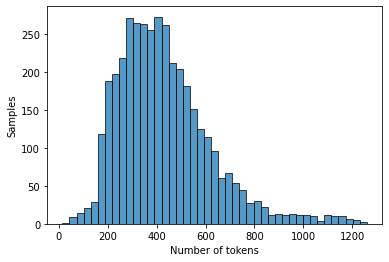

In [ ]:
hist = sns.histplot(data = num_tokens)
hist.set(xlabel = 'Number of tokens', ylabel = 'Samples')
plt.show()

In [ ]:
num_tokens.describe()

count    3911.000000
mean      430.492969
std       191.868449
min        14.000000
25%       294.000000
50%       402.000000
75%       526.500000
max      1260.000000
Name: full_text, dtype: float64

In [ ]:
train[scores].describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [ ]:
def generate_wordclouds(k = 4.5):
  # Code in this function is inspired from 
  # https://amueller.github.io/word_cloud/auto_examples/single_word.html
  # for generation of word cloud

  fig, ax = plt.subplots(1, 6, figsize=(35,35))

  for i, score in enumerate(scores):
    cloud = WordCloud(background_color = 'black', height = 1000, width = 1000)
    cloud.generate(' '.join(train.full_text[train[score] >= 5]))
    ax[i].imshow(cloud)
    ax[i].set_xlabel(score, fontsize=22)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

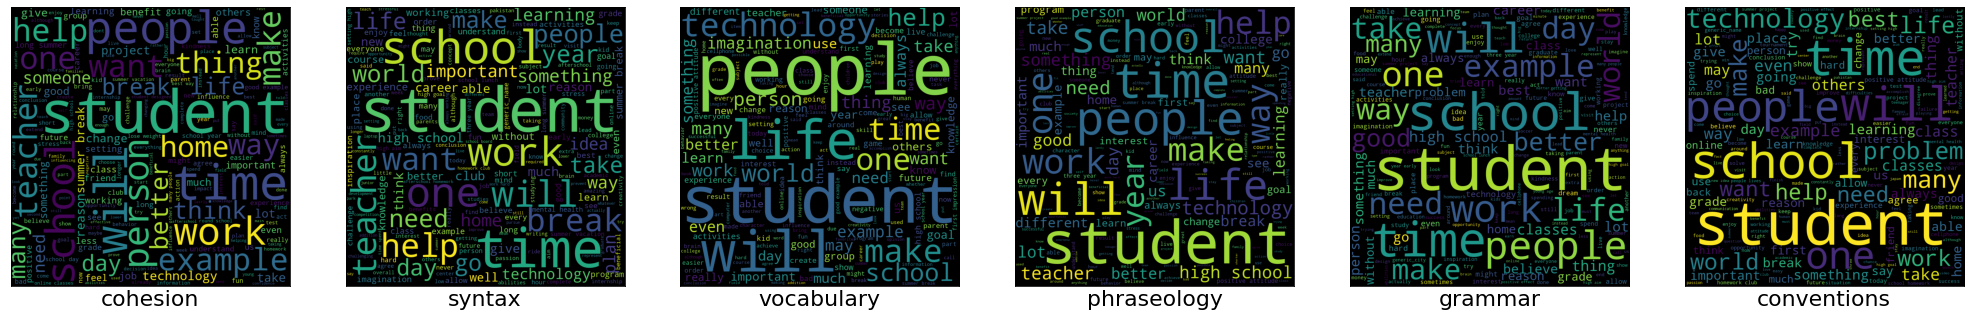

In [ ]:
generate_wordclouds()

In [ ]:
train['total_scores'] = train[scores].sum(axis = 1)

In [ ]:
train['total_scores'].describe()

count    3911.000000
mean       18.621836
std         3.365642
min         6.000000
25%        16.000000
50%        18.500000
75%        21.000000
max        30.000000
Name: total_scores, dtype: float64

In [ ]:
# Using the tokenizer from the huggingface transformers bert library to tokenize and
# pad text into max length in future cells.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Loading the data and defining the Baseline model

#### We will be recreating a modified version of the R2BERT. We have removed the ranking at the end because the dataset does not contain any topical information. We tried adding TF-IDF as an additional feature, but the model was performing better without the similarity ranking model, so we have removed that part here entirely. The rest of the model remains the same with one critical difference in hyperparameters. We have used the MCRMSE loss instead of the Q loss used in the original base paper.

In [ ]:
# Creating dataset using pytorch libraries and modules.
class train_custom_set(Dataset):
  def __init__(self, data):
    self.max_seq_len = 512
    self.sent_toks_data = data
  def __getitem__(self,idx):
    sent_tok = self.sent_toks_data['full_text'][idx]
    berttokssent = tokenizer.encode_plus(sent_tok, None,  max_length = self.max_seq_len, truncation = True, add_special_tokens = True, padding = 'max_length')
    # Can alternatively use return_tensors = 'pt' source:  https://huggingface.co/docs/transformers/v4.25.1/en/main_classes/tokenizer#transformers.PreTrainedTokenizer
    tensor_custom = {"input_ids": torch.tensor(berttokssent['input_ids'], dtype=torch.long), "token_type_ids": torch.tensor(berttokssent['token_type_ids'], dtype=torch.long), "attention_mask": torch.tensor(berttokssent['attention_mask'], dtype=torch.long)}
    #berttokssent['input_ids'] = berttokssent['input_ids'].squeeze(0)
    label = torch.tensor(self.sent_toks_data.loc[idx, scores].to_list())
    return tensor_custom, label
  def __len__(self):
    return len(self.sent_toks_data)

In [ ]:
# Dataset for validation data.
class test_custom_set(Dataset):
  def __init__(self, data):
    self.max_seq_len = 512
    self.sent_toks_data = data
  def __getitem__(self,idx):
    sent_tok = self.sent_toks_data['full_text'][idx]
    berttokssent = tokenizer.__call__(sent_tok, None, max_length = self.max_seq_len, truncation = True, add_special_tokens = True, padding = 'max_length', return_tensors = 'pt')
    # Can alternatively use return_tensors = 'pt' source:  https://huggingface.co/docs/transformers/v4.25.1/en/main_classes/tokenizer#transformers.PreTrainedTokenizer
    tensor_custom = {"input_ids": torch.tensor(berttokssent['input_ids'], dtype=torch.long), "token_type_ids": torch.tensor(berttokssent['token_type_ids'], dtype=torch.long), "attention_mask": torch.tensor(berttokssent['attention_mask'], dtype=torch.long)}
    return tensor_custom
  def __len__(self):
    return len(self.sent_toks_data)

In [ ]:
# Sampling main training dataset to split into validation dataset.
tr, va = train_test_split(train, test_size = 0.2, shuffle = True)

In [ ]:
tr = tr.reset_index(drop = True)
va = va.reset_index()
test = test.reset_index()

In [ ]:
train_dataset = train_custom_set(tr)
validation_dataset = train_custom_set(va)
test_dataset = test_custom_set(test)

In [ ]:
# Defining our custom loss
def mcrmse_loss(ot, tgt):
  '''
  Mean column-wise root mean squared loss.
  '''
  return torch.mean(torch.sqrt(torch.mean(torch.square(ot - tgt), dim = 0)))

In [ ]:
class Baseline_Model(nn.Module):
  '''
  This model feeds the input into a pretrained bert encoder. The logits are then fed
  into a dense layer which acts as a regression layer which gives us our
  final output predictions from the intermediate bert logits.
  '''
  def __init__(self):
    super(Baseline_Model, self).__init__()
    # Using the baseline bert pretrained model as used in the base paper.
    # next 2 lines adapted from https://stackoverflow.com/a/65323900
    config = BertConfig.from_pretrained('bert-base-uncased', output_attentions=True)  
    self.bertencoder = BertModel.from_pretrained("bert-base-uncased", config = config)
    self.fc = nn.Linear(768, 6)
  def forward(self, x):
    h, output, attention = self.bertencoder(**x, return_dict = False)
    output = self.fc(output)
    return output, attention


In [ ]:
model = Baseline_Model().to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Hyperparameters used in base paper. The only one that differs here is epochs because we have
# significantly lesser data so it overfits quickly.
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
batch_size = 8
epochs = 6


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validation_dataloader = DataLoader(validation_dataset, batch_size = batch_size, shuffle = True)

# Training the baseline model

In [ ]:
from tqdm.auto import tqdm

def train_model(model):
  loss_history = {'train_loss':[],'val_loss':[]}
  for epoch in range(epochs):
    progress_bar = tqdm(range((epochs * len(train_dataloader))//10))
    print(f'Epoch {epoch+1}/{epochs}')
    model.train()
    train_loss = []
    valid_loss = []
    # training loop
    for samples, labels in train_dataloader:
      #samples = samples.to(device)
      samples = {x:samples[x].to(device) for x in samples.keys()}
      labels = labels.to(device)
      #print(samples)
      #samples['input_ids'] = samples['input_ids']
      #print(samples['input_ids'].shape)
      output = model(samples)[0]

      loss = mcrmse_loss(output, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss.append(loss.detach().cpu().numpy())
      progress_bar.update(1)
    model.eval()

    # validation loop
    with torch.no_grad():
      for samples, labels in validation_dataloader:
        #samples = samples.to(device)
        samples = {x:samples[x].to(device) for x in samples.keys()}
        labels = labels.to(device)
        output = model(samples)[0]
        loss = mcrmse_loss(output, labels)
        valid_loss.append(loss.detach().cpu().numpy())
    loss_history['train_loss'].append(np.mean(train_loss))
    loss_history['val_loss'].append(np.mean(valid_loss))
      
    print('\ntrain loss {:.3f} \t val loss {:.3f}'.format(np.mean(train_loss), np.mean(valid_loss)))
  
  return loss_history

In [ ]:
model_losses = train_model(model)

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 1/6

train loss 1.242 	 val loss 0.649


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 2/6

train loss 0.573 	 val loss 0.623


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 3/6

train loss 0.510 	 val loss 0.571


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 4/6

train loss 0.480 	 val loss 0.543


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 5/6

train loss 0.466 	 val loss 0.557


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 6/6

train loss 0.449 	 val loss 0.630


In [ ]:
#train_dataset[0][0]['input_ids'].shape

In [ ]:
#torch.cuda.empty_cache()

# Plotting the results.


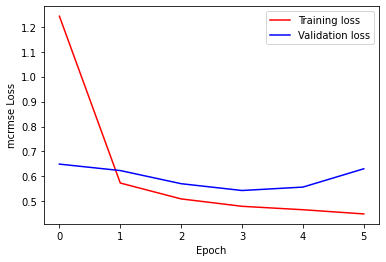

In [ ]:
plt.plot(model_losses['train_loss'], color = 'red')
plt.plot(model_losses['val_loss'], color = 'blue')
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel('Epoch')
plt.ylabel('mcrmse Loss')
plt.show()

# Investigating attention weights to see which encoder layers to freeze 

#### Taking a random sample essay

In [ ]:
with torch.no_grad():
  sample = next(iter(train_dataloader))[0]
  sample = {k:sample[k].to(device) for k in sample.keys()}
  output = model(sample)

In [ ]:
len(output[1][0])

32

In [ ]:
len(output[1][0][0])

12

In [ ]:
tokenizer.decode(sample['input_ids'][0])

'[CLS] i agree that having a positive attitude is the key to success because in life no matter what you do you need a positive attitude. for example when you go for a job interview you go into the place with a positive attitude of you wont get the job. its like getting a job you have to have a positive attitude when your working with your others or with customers. i think that in life everyone needs a positive attitude to accomplish there goals. i think that people that doesnt have a positive attitude wont get very far in life. because when i was in middle school i never had a positive attitude and i would get into a lot of trouble because of my attitude, and now that my attitude has changed im becoming successful in life. i think that in everything you do in life requires a positive attitude. you need a positive attitude when your talking to people. if you have a negative attitude people wouldnt want to be bothered by you because people dont like to be around people with a negative at

#### Generate attention map by overlaying on grid

In [ ]:
def layer_attn(outputs, layer=0, ah=0):

  return (outputs[layer]).unsqueeze(0)[ah][:10,:10]


In [ ]:
layer_attn(output[1][0][0]).shape

torch.Size([10, 10])

In [ ]:
def hist_attn_matrix(gridm, labels, fs=(10,10)):
  fig, ax = plt.subplots(figsize=fs) 
  ax = sns.heatmap(gridm.detach().numpy(), annot= False)
  ax.xaxis.set_ticks_position('top')
  ax.set_xticklabels(labels, rotation=45)
  ax.set_yticklabels(labels, rotation=45)

In [ ]:
labano = tokenizer.decode(sample['input_ids'][0]).split()[:10]


#### These are the tokens that will be mapped for this visualization

In [ ]:
labano

['[CLS]',
 'i',
 'agree',
 'that',
 'having',
 'a',
 'positive',
 'attitude',
 'is',
 'the']

In [ ]:
type(labano)

list

#### Visualizing layer 0 attention head we see that there is a high correlation between starting instances. This seems to be attending to staring sequences which we would otherwise see in other samples as well if the same layer is visualized. For example, 'a' after CLS has a large activation weight.

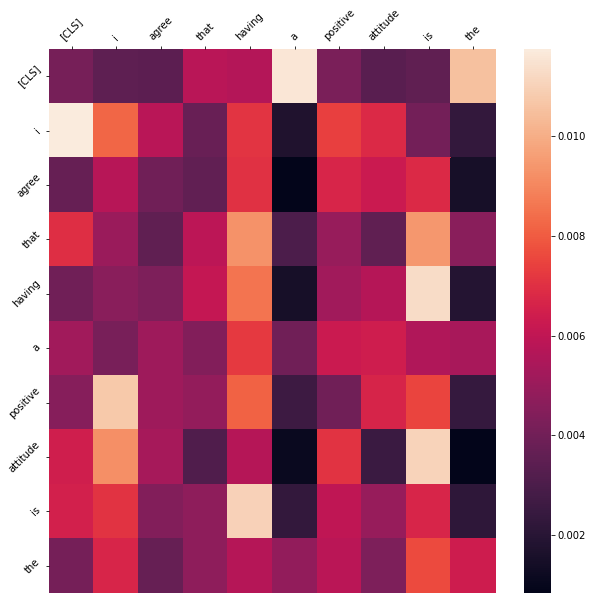

In [ ]:
hist_attn_matrix(layer_attn(output[1][0][0], 0).cpu().detach(), labano)

#### Here at layer 1 we see a littel different result. It looks like this layer is more concerned with the CLS token and certain connecting terms that are commonly seen in our dataset if we recall the word cloud we had generated before.

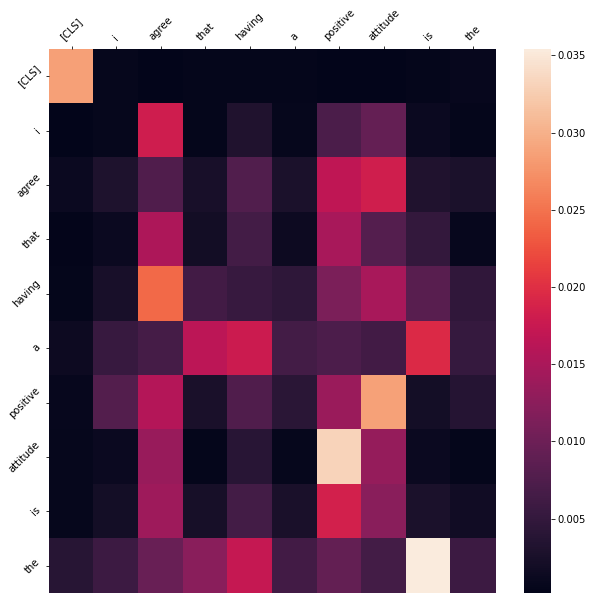

In [ ]:
hist_attn_matrix(layer_attn(output[1][0][0], 1).cpu().detach(), labano)

#### This layer seems to be attending to a similar trend as we saw in the last layer.

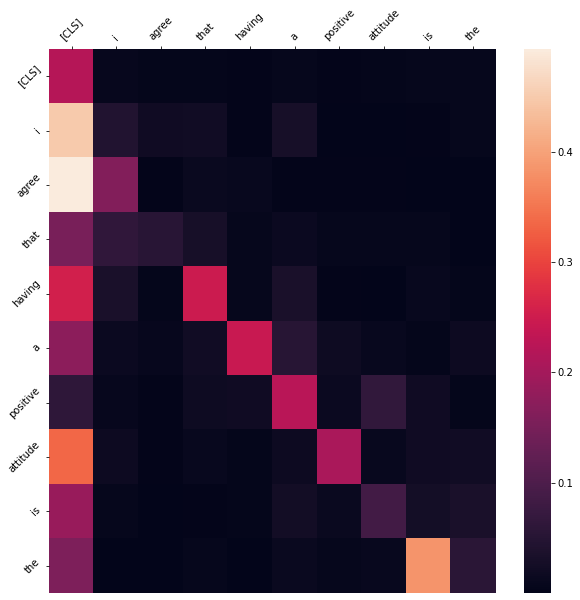

In [ ]:
hist_attn_matrix(layer_attn(output[1][0][0], 2).cpu().detach(), labano)

#### This layer is actually attending to the next token in sequence very consistently.

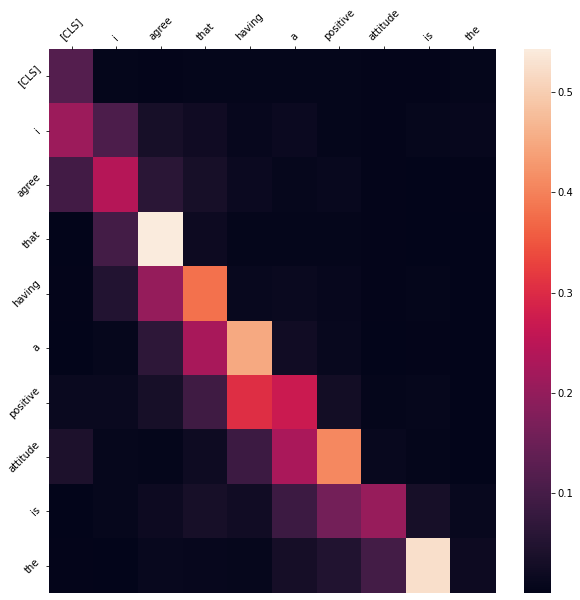

In [ ]:
hist_attn_matrix(layer_attn(output[1][0][0], 3).cpu().detach(), labano)

####  The next layer is only attending to the CLS token!

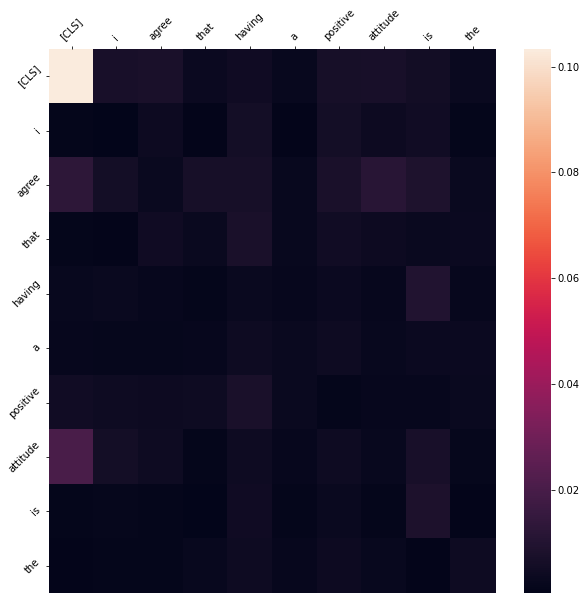

In [ ]:
hist_attn_matrix(layer_attn(output[1][0][0], 4).cpu().detach(), labano)

#### This layer seems to be attending to affirmative vocabulary.

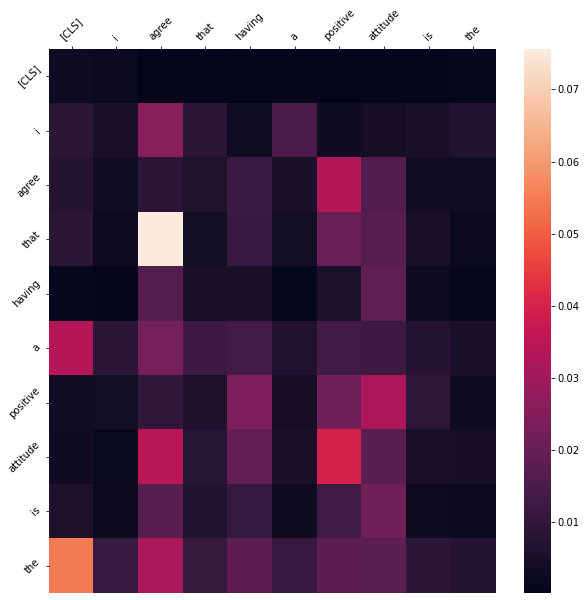

In [ ]:
hist_attn_matrix(layer_attn(output[1][0][0], 5).cpu().detach(), labano)

#### We aren't sure what this layer is attending to but our guess is that it is attending to certain possesive connectives.

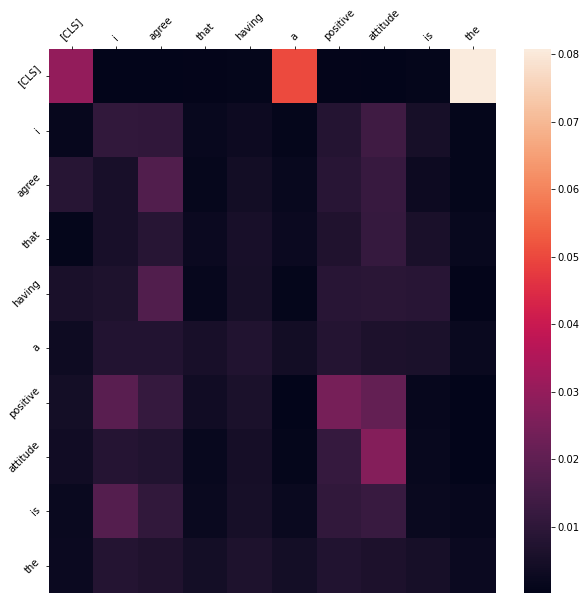

In [ ]:
hist_attn_matrix(layer_attn(output[1][0][0], 6).cpu().detach(), labano)

#### Now we see some interesting attention weights at this layer. It looks like it is attending to certain clusters of semantics such as 'attitude' being 'positive' or 'having' an 'attitude' which is 'agree'd

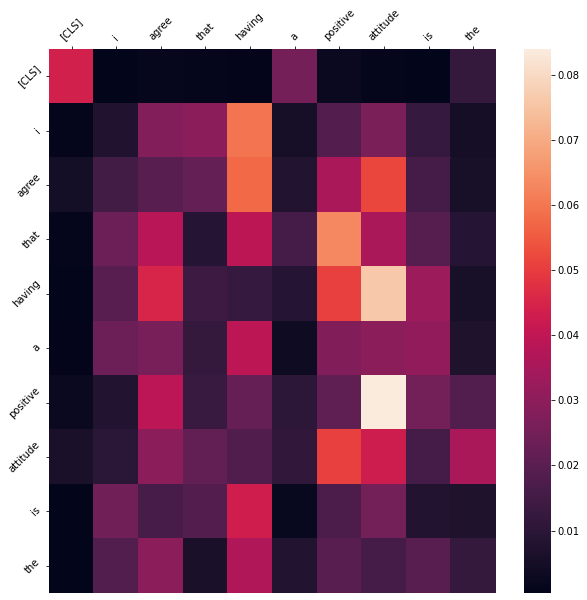

In [ ]:
hist_attn_matrix(layer_attn(output[1][0][0], 8).cpu().detach(), labano)

#### Another layer with a more nuanced attention matrix. While this may look similar to layer 3 which was attending to the next token, this is not activating on an average level for all of them. There is a much larger activation for certain phrases here. For example, 'I' 'agree' has a higher attention. The next tokens all trickle down to lower attention. This is like saying what does the person agree with? - and following up after. We can see this rise in attention suddenly drops at 'a' because that is not critical in what the subject 'agrees' with.

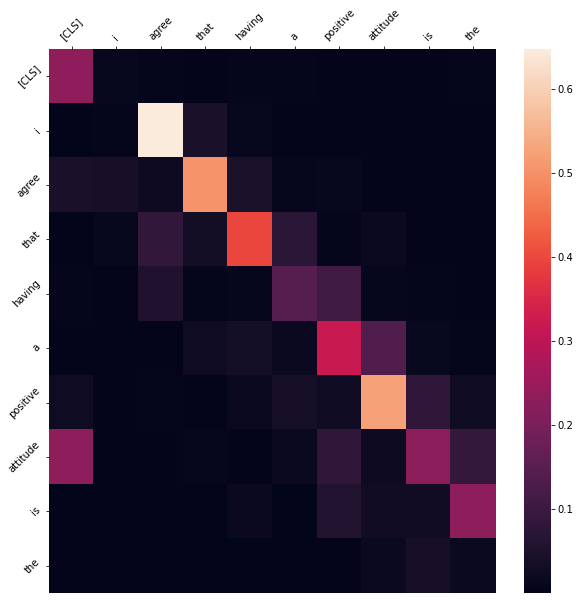

In [ ]:
hist_attn_matrix(layer_attn(output[1][0][0], 10).cpu().detach(), labano)